## Import the packages / functions

In [21]:
import sys
sys.path.append("../../neuralflow") # append the path for the 'neuralflow' directory 

from jax.config import config

config.update("jax_log_compiles", 1)
# config.update("jax_debug_nans", True)

import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datagen.diffeq import gen_diffeq, vanderpol, lorenz
from jax.experimental.optimizers import adam
from matplotlib.animation import FuncAnimation
from models import kernels
from models.rbfn import RBFN
from scipy.integrate import solve_ivp

from scripts.visualize import draw_vec_bg

sns.set()

In [22]:
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.decomposition import PCA

from tqdm.notebook import trange

from datagen import plots
from datagen.diffeq import lorenz


def random_proj(initial_dim: int, dim: int, seed=4):
    """
    Generate random Gaussian matrix with normalized columns.
    """
    rand = np.random.default_rng(seed)
    t = rand.normal(0, 1, size=(dim, initial_dim))
    return (t / np.sum(t, axis=0)).T


def random_rotation(initial_dim: int, dim: int, θ: float, seed=4):
    rot = np.array(
        [
            [np.cos(θ), -np.sin(θ)],
            [np.sin(θ), np.cos(θ)],
        ]
    )
    out = np.zeros((dim, dim))
    out[:2, :2] = rot
    rand = np.random.default_rng(seed)
    q = np.linalg.qr(rand.normal(0, 1, size=(dim, dim)))[0]
    return q @ out @ q.T


# fmt: off
def gen_data_diffeq(f: Callable, projection: Callable, *, t, x0: np.ndarray, dim: int,
                    ivp_kwargs: Optional[dict] = None, proj_kwargs: Optional[dict] = None,
                    noise: Optional[str] = None, noise_kwargs: Optional[dict] = None,
                    seed=41):  # fmt: skip 
# fmt: on

    """Data generation pipeline
    Solve dynamical system, project into higher dimension, add noise.
    
    Args:
        f (Callable): Diff function to solve.
        projection (Callable): Proj function. Must have signature (initial_dim, dim, **kwargs) and output matrix (initial_dim × dim).
        t: Time for diff eq. See solve_ivp documentation.
        x0 (np.ndarray): Starting point.
        dim (int): Projected number of dimensions.
        ivp_args (Optional[dict]): Args to solve_ivp. Defaults to None.
        noise (Optional[str]): Name of noise function from https://numpy.org/doc/stable/reference/random/generator.html
        noise_params (Optional[dict]): Params to noise function. Defaults to None.
        seed (int): Defaults to 41.
    Returns:
        t, y (t × initial_dim), projected (t × dim)
    """
    if ivp_kwargs is None:
        ivp_kwargs = dict()
    if proj_kwargs is None:
        proj_kwargs = dict()
    if noise_kwargs is None:
        noise_kwargs = dict()

    ivp = solve_ivp(f, t, x0, rtol=1e-6, **ivp_kwargs)

    y = ivp["y"].T  # (t × dim)
    proj = projection(y.shape[1], dim, **proj_kwargs)
    projed = y @ proj

    if noise is not None:
        rand = np.random.default_rng(seed)
        projed += getattr(rand, noise)(**noise_kwargs, size=projed.shape)

    return ivp["t"], y, projed

## Lorenz attractor data generation example

Dataset starting at 0, so (0:2000)

num_trajectory = 100 

noise = 0.05

In [23]:
xx = [] # states
projeds = [] # observations
num_trajectories = 100 # number of trajectories 
num_dim = 200 # projected dimensinos
begin = 0 # change to 500 if you don't want to include first 500
end = 2000 # change to 2500 if you changed begin = 500 
noise = 0.05 # standard deviation of the gaussian noise 
for i in trange(num_trajectories):
    t, x, projed = gen_data_diffeq(lorenz, random_proj,
                                   t=(0, 125), x0=np.array([0, 1, 1.05]), dim=num_dim, noise="normal", 
                                   ivp_kwargs={'max_step': 0.05},
                                   noise_kwargs={"loc": 0, "scale": noise},)
    t = t[begin:end]
    xx.append(x[begin:end])
    projeds.append(projed[begin:end])
    
xx = np.stack(xx, axis=0)
projeds = np.stack(projeds, axis=0)

xx.shape, projeds.shape

((100, 2000, 3), (100, 2000, 200))

In [24]:
t.shape

(2000,)

In [25]:
xx.shape

(100, 2000, 3)

In [26]:
projeds.shape

(100, 2000, 200)

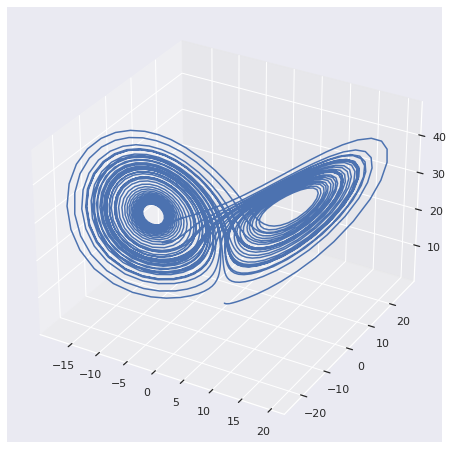

11414.20964773698

In [27]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*xx[11].T)

plt.show()
np.linalg.norm(np.diff(x, axis=-2), axis=-1).sum(axis=-1)

In [28]:
xs = xx
ys = projeds
us = np.zeros((xx.shape[0], xx.shape[1], 1))

In [29]:
filename = f"lorenz_{num_trajectories}trajectories_{num_dim}dim_{begin}to{end}_noise{noise}.npz"
np.savez(filename, x = xs, y = ys, u = us)

## Now let's make a bunch

In [30]:
def make_lorenz_dataset(num_trajectories, num_dim, begin, end, noise):
    xx = [] # states
    projeds = [] # observations

    for i in trange(num_trajectories):
        t, x, projed = gen_data_diffeq(lorenz, random_proj,
                                       t=(0, 125), x0=np.array([0, 1, 1.05]), dim=num_dim, noise="normal", 
                                       ivp_kwargs={'max_step': 0.05},
                                       noise_kwargs={"loc": 0, "scale": noise},)
        t = t[begin:end]
        xx.append(x[begin:end])
        projeds.append(projed[begin:end])

    xx = np.stack(xx, axis=0)
    projeds = np.stack(projeds, axis=0)

    xs = xx
    ys = projeds
    us = np.zeros((xx.shape[0], xx.shape[1], 1))

    filename = f"lorenz_{num_trajectories}trajectories_{num_dim}dim_{begin}to{end}_noise{noise}.npz"
    np.savez(filename, x = xs, y = ys, u = us)

* begin/end: not ommiting first 500 --> begin=0, end=2000   OR   ommiting first 500 --> begin:500, end=2500

* num_trajectory = 1   OR  100  

* noise level: noise = 0.05   OR   0.2    OR    1
(0.05 is the value Anne used, 1 is the value that memming's lab used)

* num_dim = 1 OR 200 
(200 is the value that memming's lab used)

2 x 2 x 3 x 2 = 24 example datasets

In [31]:
for num_trajectory in [1, 100]:
    for (begin, end) in [(0, 2000), (500, 2500)]:
        for noise in [0.05, 0.2, 1]:
            for num_dim in [1, 200]:
                make_lorenz_dataset(num_trajectories=num_trajectory, num_dim=num_dim, begin=begin, end=end, noise=noise)